Optimized Parameters:
A1: 0.0344733651017692
g1: 0.48089099282412834
A2: 0.01
g2: 0.9850254662684076
kb1: 0.0007023572801101479
b1: 0.0
kb2: 1.123358816627156
b2: 0.10981964897470553


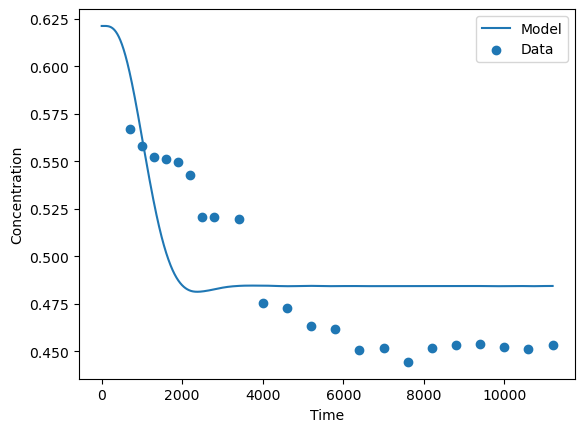

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# Given data
Time = np.array([700, 1000, 1300, 1600, 1900, 2200, 2500, 2800, 3400, 4000, 4600, 5200, 5800, 6400, 7000, 7600, 8200, 8800, 9400, 10000, 10600,11200])
Concentration = np.array([0.567100911,0.55806661,0.552402276,0.551438362,0.549870445,0.542640664,0.520739187,0.520630394,0.519500363,0.475518394,0.472627019,0.463479808,0.46155871,0.450828366,0.451514849,0.444370262,0.451795351,0.453523969,0.453676045,0.452259622,0.451143698,0.453071627])

def generateODE2(t, m, A1, g1, A2, g2, kb1, b1,kb2,b2, V):
    # Unpack the variables from the y vector
    m00, m10, m01, m11, c = m

    Ci = 0.6215                     # gm/(100 gm of mixed solvent)
    Ce = 0.383                      # gm/(100 gm of mixed solvent)
    
    # Calculate necessary quantities
    
    f = 5 * 10**-7                     # m3/sec 
    ρc = 1400 * 10**3                    # gm/m3
    h = 1 * 10**(-5)                     # m
    Vc = h * m11
    ρl = 785 * 10**3                     # gm/m3
    V = 0.0002
    tau = V / f
    
    delta_c = max(c - Ce, 0)
    s = delta_c / Ce
    
    Gl = A1 * (s)**g1
    Gw = A2 * (s)**g2
    B = kb1 * (s)**b1  + kb2*Vc*s**b2

    dm00 = B - (m00 / tau)
    dm10 = (Gl * m00) - (m10 / tau)
    dm01 = (Gw * m00) - (m01 / tau)
    dm11 = (Gl * m10) + (Gw * m01) - (m11 / tau)
    dc = (Ci / tau) - (c / tau) - (ρc / ρl) * Vc

    return [dm00, dm10, dm01, dm11, dc]

def objective(params):
    A1, g1, A2, g2, kb1, b1, kb2, b2  = params
    V = 0.0002                        # Volume, adjust as needed
    t_span = (0, 11000)               # Adjust this to match the maximum time in your data
    num_points = 11000
    initialConditions = [0, 0, 0, 0, 0.6213]
    sol = solve_ivp(
        lambda t, m: generateODE2(t, m, A1, g1, A2, g2, kb1, b1,kb2,b2, V),
        t_span,
        initialConditions,
        t_eval=np.linspace(t_span[0], t_span[1], num_points)
    )
    
    # Ensure that the interpolation is within the range of the solution
    interp_t = np.clip(Time, sol.t[0], sol.t[-1])
    
    # Interpolate the solution at the time points specified in Time
    interp_solution = interp1d(sol.t, sol.y[4], bounds_error=False, fill_value="extrapolate")
    model_predictions = interp_solution(Time)
    error = np.sum((model_predictions - Concentration)**2)  # Sum of squared differences
    return error

# Initial guess for parameters
initial_guess =  [0.00001313983, 1, 0.00002593650, 1.43, 0.03, 0.19, 1.12,0.1172]

# Bounds for the parameters
bounds = [(0, 0.1),   # A1
          (0, 2),      # g1
          (0, 0.01),     # A2
          (0, 1),        # g2
          (0, 2),        # kb1
          (0, 2),          #b1
         (0, 2),         #kb2
         (0,2)]         # b2

# Minimize the objective function with bounds
result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=bounds)

# Extract the optimized parameters
A1_opt, g1_opt, A2_opt, g2_opt, kb1_opt, b1_opt, kb2_opt, b2_opt = result.x
print("Optimized Parameters:")
print("A1:", A1_opt)
print("g1:", g1_opt)
print("A2:", A2_opt)
print("g2:", g2_opt)
print("kb1:", kb1_opt)
print("b1:", b1_opt)
print("kb2:", kb2_opt)
print("b2:", b2_opt)

# Plot the optimized model against the data
t_span = (0, 11200)
num_points = 11200
initialConditions = [0, 0, 0, 0, 0.6213]
sol = solve_ivp(
    lambda t, m: generateODE2(t, m, A1_opt, g1_opt, A2_opt, g2_opt, kb1_opt, b1_opt, kb2_opt, b2_opt, 0.0002),
    t_span,
    initialConditions,
    t_eval=np.linspace(t_span[0], t_span[1], num_points)
)
plt.plot(sol.t, sol.y[4], label='Model')
plt.scatter(Time, Concentration, label='Data')
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.legend()
plt.show()

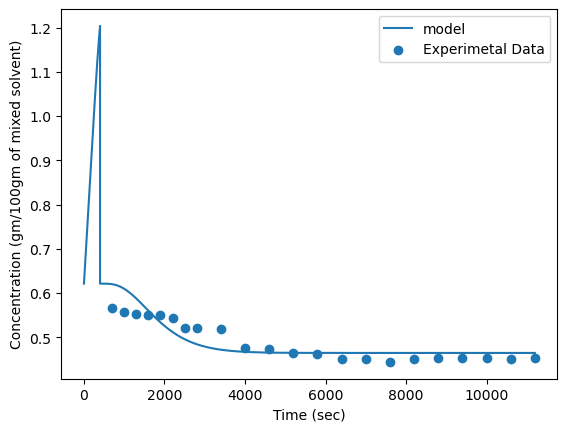

In [2]:
def generateODE(t, m):
    # Unpack the variables from the y vector
    m00, m10, m01, m11,c = m

    Ci=0.6215                     #gm/(100 gm of mixed solvent)
    Ce=0.383                      #gm/(100 gm of mixed solvent)
    
    #calulate neccessary quantity
    
    A1 = 0.01             # m/s 
    A2 = 0.01        # m/s
    g1 = 2
    g2 = 0.001
    kb = 0.00344                        # m3/sec
    b = 0.001
    R = 8.314                        # joule\(k mol)
    T = 303.14                       # kelvin
    V = 0.0002                       # m3
    
    f= 5*10**-7                     # m3/sec 
    
    
    ρc = 1400*10**3                    # gm/m3
    h = 1*10**(-5)                     # m
    Vc = h*m11
    
    ρl = 785*10**3                     # gm/m3
    
    
    # Canti=np.linspace(0,1000,120)
    # Ce= ((-2*10**(-6)*Canti**3)+(0.0003*Canti**2)+(-0.0274*Canti)+1.232)
    
    delta_c = max(c-Ce,0)
    s= delta_c/Ce
    
    k=3.14/6
    tau = V/f
    
    Gl=A1*(s)**g1
    
    Gw=A2*(s)**g2
    
    B= kb*(s)**b                                #B= kJ1*math.exp((-kJ2)/(np.log((s)**2)))
    
    dm00= B 
    dm10=(Gl*m00)
    dm01=(Gw*m00)
    dm11=(Gl*m10)+(Gw*m01)
    
    #dm20=(2*Gl*m10)+(-m20/tau)
    #dc=(Ci/tau)-(c/tau)-(g*(2*Gl*m11-Gl*m20+Gw*m20))
    
    dc=(Ci/tau)-(ρc/ρl)*Vc

    return [dm00, dm10, dm01, dm11,dc]
t_span=(0,400)
num_points_0= 400
initialConditions = [0, 0, 0, 0,0.6213]
sol1= solve_ivp(
    lambda t,m: generateODE(t,m),
    t_span,
    initialConditions,
    t_eval=np.linspace(t_span[0], t_span[1], num_points_0)
)
plt.plot(np.append(sol1.t,sol.t),np.append(sol1.y[4], sol.y[4]), label ="model")
plt.scatter(Time, Concentration, label='Experimetal Data')
plt.xlabel("Time (sec)")
plt.ylabel("Concentration (gm/100gm of mixed solvent)")
plt.legend()
plt.show()

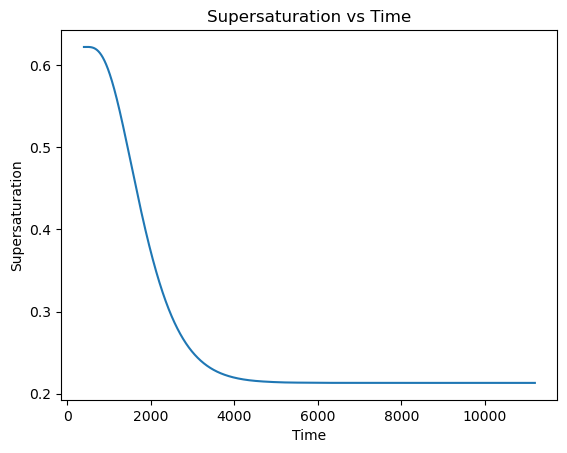

In [3]:
plt.plot(sol.t, ((sol.y[4] - 0.383) / 0.383))
plt.xlabel("Time")
plt.ylabel("Supersaturation")
plt.title("Supersaturation vs Time")
plt.show()

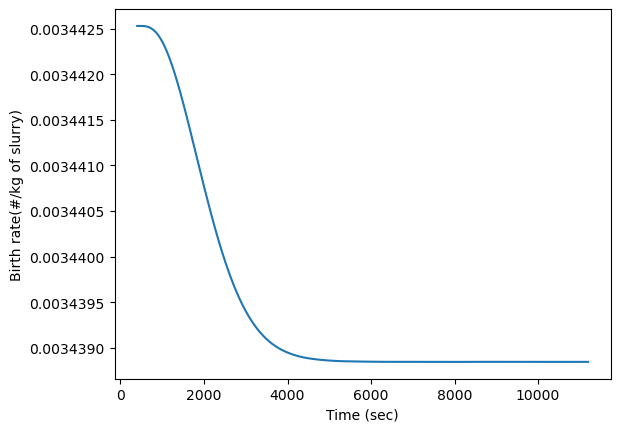

In [4]:
plt.plot(sol.t, kb_opt * ((sol.y[4] - 0.383) / 0.383)**b_opt)
plt.xlabel("Time (sec)")
plt.ylabel("Birth rate(#/kg of slurry)")
plt.show()

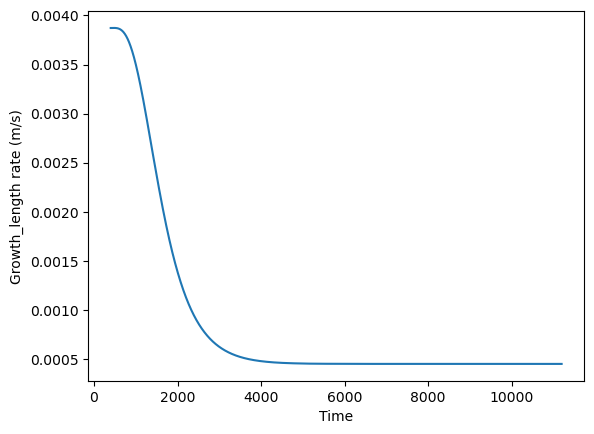

In [5]:
plt.plot(sol.t, A1_opt * ((sol.y[4] - 0.383) / 0.383)**g1_opt)
plt.xlabel("Time")
plt.ylabel("Growth_length rate (m/s)")
plt.show()

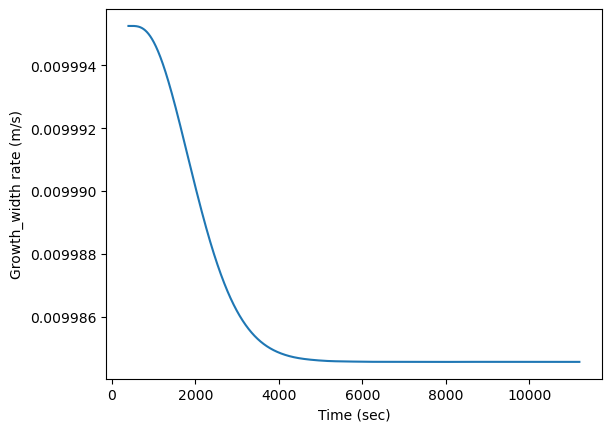

In [6]:
plt.plot(sol.t, A2_opt * ((sol.y[4] - 0.383) / 0.383)**g2_opt)
plt.xlabel("Time (sec)")
plt.ylabel("Growth_width rate (m/s)")
plt.show()

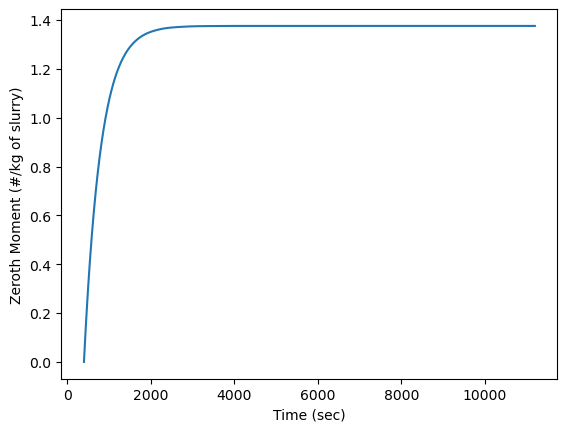

In [7]:
plt.plot(sol.t, sol.y[0], label='Model')
plt.xlabel("Time (sec)")
plt.ylabel("Zeroth Moment (#/kg of slurry)")
plt.show()

C:\Users\heman\AppData\Local\Temp\ipykernel_8196\1358489055.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(sol.t,sol.y[1]/ sol.y[0], label='Model')


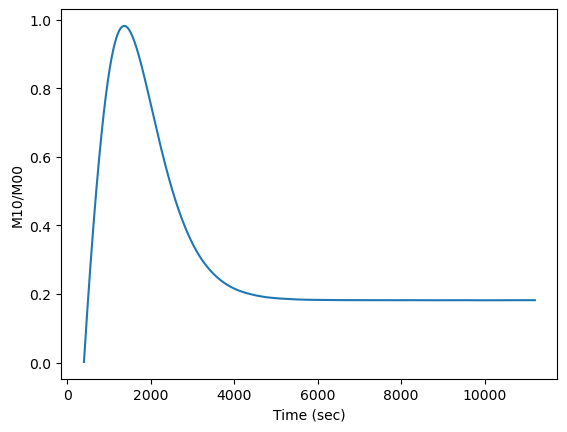

In [8]:
plt.plot(sol.t,sol.y[1]/ sol.y[0], label='Model')
plt.xlabel("Time (sec)")
plt.ylabel("M10/M00")
plt.show()

C:\Users\heman\AppData\Local\Temp\ipykernel_8196\1277339380.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(sol.t,sol.y[2]/ sol.y[0], label='Model')


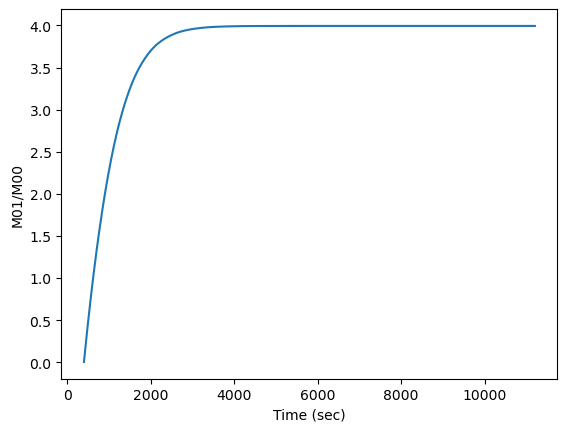

In [10]:
plt.plot(sol.t,sol.y[2]/ sol.y[0], label='Model')
plt.xlabel("Time (sec)")
plt.ylabel("M01/M00")
plt.show()